## Incorporating the Reimannian metric A in optimization
Requires an optimization method that can take a Hessian or a Hessian-Product as input.

[SciPy Optimize Reference](http://docs.scipy.org/doc/scipy-0.14.0/reference/tutorial/optimize.html)

In [4]:
%matplotlib inline
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt

In [5]:
class SDFSphere(object):
    def __init__(self, x, r):
        self.x = x
        self.r = r
    def sdf(self, p):
        return np.linalg.norm(p - self.x) - self.r
    def sdfgrad(self, p):
        import warnings
        with warnings.catch_warnings():
            warnings.filterwarnings('error')
            try:
                grad = (p - self.x)/np.linalg.norm(p - self.x)
            except Warning as e:
                grad = np.zeros(p.shape)
        return grad

class SDFAABB(object):
    def __init__(self, x, dim):
        self.x = x
        self.dim = dim
    def sdfandgrad(self, p):
        sdfgrad = np.zeros(p.shape)
        diff = (np.absolute(p - self.x) - self.dim)
        pos = diff[diff >= 0.]
        if pos.shape[0] == 0:
            sdf = np.max(diff)
            i = np.argmax(diff)
        else:
            sdf = np.linalg.norm(pos)
            i = np.where(diff >= 0.)
        sdfgrad[i] = 1
        sdfgrad = np.sign(p - self.x)*sdfgrad/np.linalg.norm(sdfgrad)
        return sdf, sdfgrad
    def sdf(self, p):
        return self.sdfandgrad(p)[0]
    def sdfgrad(self, p):
        return self.sdfandgrad(p)[1]
            
class SDFSoup(object):
    def __init__(self, geoms):
        self.geoms = geoms
    def sdf(self, p):
        return np.min([s.sdf(p) for s in self.geoms])
    def sdfgrad(self, p):
        i = np.argmin([s.sdf(p) for s in self.geoms])
        return self.geoms[i].sdfgrad(p)

In [6]:
geoms = []
geoms.append(SDFSphere(np.asarray([0.25, 0.25]), 0.2))
geoms.append(SDFSphere(np.asarray([0.75, 0.75]), 0.2))
geoms.append(SDFAABB(np.asarray([0.5, 0.5]), np.asarray([0.2, 0.2])))
sdf = SDFSoup(geoms)

In [79]:
class SDFCost(object):
    def __init__(self, eps, k):
        self.eps = eps
        self.k = k
    def costandgradient(self, sdf):
        if (sdf > self.eps):
            return 0., 0.
        elif (sdf > 0.):
            return (self.k/2)*(sdf - self.eps)**2, self.k*(sdf - self.eps) 
        else:
            return self.k*self.eps*((self.eps/2) - sdf), -self.k*self.eps
    def cost(self, sdf):
        return self.costandgradient(sdf)[0]
    def gradient(self, sdf):
        return self.costandgradient(sdf)[1]

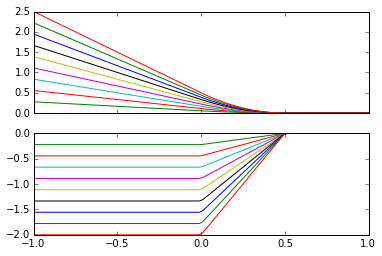

In [92]:
x = np.linspace(-1, 1, 100)
c = SDFCost(0.5, 0.)
fig, (ax0, ax1) = plt.subplots(2,1, sharex=True)
for k in np.linspace(0., 4., 10):
    c.k = k
    ax0.plot(x, [c.cost(xx) for xx in x])
    ax1.plot(x, [c.gradient(xx) for xx in x])

In [8]:
# From http://stackoverflow.com/questions/20144529/shifted-colorbar-matplotlib
from matplotlib.colors import Normalize

class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

<matplotlib.colorbar.Colorbar instance at 0x10fd20950>

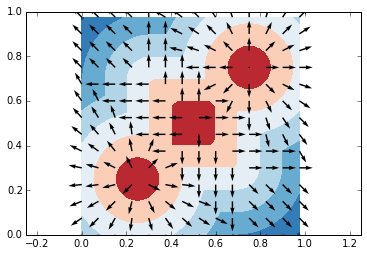

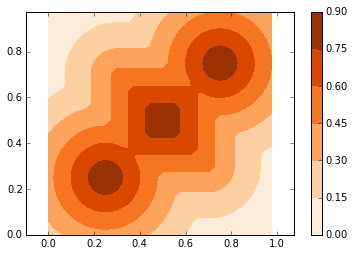

In [87]:
delta = 0.025
x = np.arange(0, 1.0, delta)
y = np.arange(0, 1.0, delta)
X, Y = np.meshgrid(x, y)
pts = np.vstack((X.flatten(), Y.flatten())).T
SDF = np.asarray([sdf.sdf(p) for p in pts])
SDFgrad = np.asarray([sdf.sdfgrad(p) for p in pts])
SDFgrad = SDFgrad.reshape((X.shape[0], X.shape[1], SDFgrad.shape[1]))
norm = MidpointNormalize(midpoint=0.)
plt.contourf(X, Y, SDF.reshape(X.shape), norm=norm, cmap=plt.cm.RdBu)
plt.hold()
plt.quiver(X[::3, ::3], Y[::3, ::3], SDFgrad[::3, ::3, 0], SDFgrad[::3, ::3, 1], units='width')
plt.axis('equal')
eps = 0.5
k = 0.1
C = np.asarray([c.cost(z) for z in SDF])
plt.figure()
plt.axis('equal')
CS = plt.contourf(X, Y, C.reshape(X.shape), cmap=plt.cm.Oranges)
plt.colorbar()

In [303]:
class Trajectory(object):
    def __init__(self, points):
        self.p = points
        self.npts, self.ndim = points.shape
    def vel(self):
        return self.p[1:] - self.p[:-1]
    def acc(self):
        return 2*self.p[1:-1] - self.p[2:] - self.p[0:-2]
    def curvature(self):
        proj = self.proj()
        return np.squeeze(np.asarray([np.dot(proj[i,:], a[:,np.newaxis])/np.linalg.norm(vel[i])**2 for i, a in enumerate(acc)]))
    def proj(self):
        vel = self.vel()
        velunit = vel/np.linalg.norm(vel)
        acc = self.acc()
        return np.asarray([np.eye(self.ndim) - np.dot(v[:,np.newaxis],t[:,np.newaxis].T ) for v in velunit])

In [315]:
class Obstacle(object):
    def __init__(self, sdf, sdfcost):
        self.sdf = sdf
        self.sdfcost = sdfcost
    def cost(self, traj):
        return np.sum([self.sdfcost.cost(self.sdf.sdf(p)) for p in traj.p])
    def gradient(self, traj):
        return np.asarray([self.sdfcost.gradient(self.sdf.sdf(p))*self.sdf.sdfgrad(p) for p in traj.p])

In [316]:
obs = Obstacle(sdf, SDFCost(0.5, 1.0))

In [317]:
class Smoothness(object):
    @staticmethod
    def cost(traj):
        fsmooth = 0.5*np.sum(np.linalg.norm(traj.vel(),axis=1)**2)
        return npts*fsmooth
    @staticmethod
    def gradient(traj):
        grad = traj.acc()
        return grad
    @staticmethod
    def hessian(traj):
        npts = traj.npts - 2
        ndim = traj.ndim
        hess = np.diag([2]*npts*ndim)
        rows = np.arange(0, npts*ndim - ndim)
        cols = np.arange(ndim, npts*ndim)
        hess[rows, cols] = -1
        hess[cols, rows] = -1
        return hess

In [318]:
class CHOMP(object):
    def __init__(self, costs, weights):
        self.costs = costs
        self.weights = weights
    def set_traj(self, traj):
        self.traj = Trajectory(traj)
    def optimize(self, x0):
        self.set_traj(x0)
        hess = Smoothness.hessian(self.traj)
        def unflat(x):
            traj = x.reshape(x.shape[0]/self.traj.ndim, self.traj.ndim)
            self.traj.p[1:-1,:] = traj
        def flat(y):
            return y.flatten()
        def fn(x):
            unflat(x)
            costs = self.weights*np.asarray([c.cost(self.traj) for c in self.costs])
            return Smoothness.cost(self.traj) + np.sum(costs)
        def jac(x):
            unflat(x)
            gradients = self.weights*np.asarray([c.gradient(self.traj) for c in self.costs])
            return flat(Smoothness.gradient(self.traj) + np.sum(gradients))
        def hessian(x):
            return hess
        tall = []
        def fn_call(x):
            from copy import deepcopy
            unflat(x)
            tall.append(deepcopy(self.traj.p))    
        res = scipy.optimize.minimize(fn, flat(self.traj.p[1:-1,:]), method='Newton-CG', jac=jac, hess=hessian, callback=fn_call)
        return res, np.asarray(tall)

In [319]:
sidd = CHOMP([obs], 0.)
ndim = 2
npts = 20
xs = np.zeros(ndim)
xt = np.ones(ndim)
x0 = np.random.rand(npts, ndim)
x0 = np.vstack((xs, x0, xt))
res, tall = sidd.optimize(x0)
print res['message']
print 'Evals:', res['nfev'], '+', res['njev'], '+', res['nhev'], '=', res['njev'] + res['nfev'] + res['nhev']

Optimization terminated successfully.
Evals: 11 + 20 + 10 = 41


In [128]:
def animate_traj(tall, fname='traj.mp4'):
    import matplotlib.animation as animation
    fig = plt.figure()
    def update(i):
        traj = tall[i]
        plt.cla()
        plt.axis([-0.2, 1.2, -0.2, 1.2])
        return plt.plot(traj[:, 0], traj[:, 1], 'ro-')
    ani = animation.FuncAnimation(fig, update, frames=len(tall))
    ani.save(fname)
    return ani

In [246]:
def plot_traj(tall):
    import matplotlib.pyplot as plt
    import matplotlib.animation as animation
    import matplotlib.cm as cm
    numplot = 10.
    mycm = cm.RdYlGn
    for j, i in enumerate(np.linspace(0, tall.shape[0]-1, numplot, dtype=np.int64)):
        traj = tall[i]
        im = plt.plot(traj[:, 0], traj[:, 1], 'o-', color=mycm(j/numplot))
    plt.axis([-0.2, 1.2, -0.2, 1.2])

3.48755447561 0.952380952381


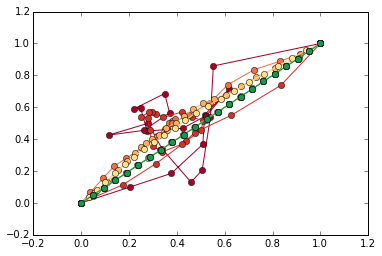

In [247]:
plot_traj(tall)
print obs.cost(tall[-1]), Smoothness.cost(tall[-1])

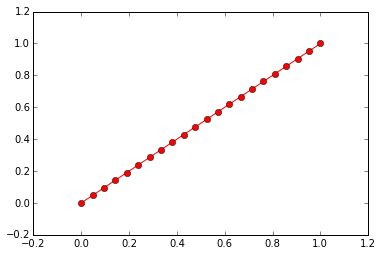

In [248]:
ani = animate_traj(tall)

In [146]:
sidd = [3.4, 4.5]

In [148]:
print sidd[0]/len(sidd)

1.7


In [212]:
traj = 0.5*np.linspace(0,1,20)**2
traj = np.vstack((traj, traj)).T

In [213]:
Smoothness.gradient(traj)

array([[-0.00277008, -0.00277008],
       [-0.00277008, -0.00277008],
       [-0.00277008, -0.00277008],
       [-0.00277008, -0.00277008],
       [-0.00277008, -0.00277008],
       [-0.00277008, -0.00277008],
       [-0.00277008, -0.00277008],
       [-0.00277008, -0.00277008],
       [-0.00277008, -0.00277008],
       [-0.00277008, -0.00277008],
       [-0.00277008, -0.00277008],
       [-0.00277008, -0.00277008],
       [-0.00277008, -0.00277008],
       [-0.00277008, -0.00277008],
       [-0.00277008, -0.00277008],
       [-0.00277008, -0.00277008],
       [-0.00277008, -0.00277008],
       [-0.00277008, -0.00277008]])

In [239]:
npts, ndim = traj[1:-1,:].shape
print np.sum([np.linalg.norm(traj[i,:] - traj[i-1,:])**2 for i in range(1, npts+2)])
print np.sum(np.linalg.norm((traj[1:,:]-traj[:-1,:]),axis=1)**2)

0.0350634203237
0.0350634203237


In [238]:
print len([traj[i,:] - traj[i-1,:] for i in range(1, npts+2)])

19


In [236]:
print (traj[1:-1,:]-traj[:-2,:]).shape

(18, 2)


In [253]:
sidd = np.arange(10)
print sidd[:]

[0 1 2 3 4 5 6 7 8 9]


In [286]:
babs =  np.asarray([np.dot(t[:,np.newaxis],t[:,np.newaxis].T ) for t in traj])
print traj[1,:].shape

(2,)


In [305]:
babs = Trajectory(tall[-1])
print babs.p.shape, babs.vel().shape, babs.acc().shape
print babs.curvature().shape

(22, 2) (21, 2) (20, 2)
(20, 2)


In [297]:
traj.shape

(20, 2)